In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

from mapie.regression import MapieQuantileRegressor

import sys
sys.path.insert(0,'./') # neccesary to load constants module
import constants as const

SEED = 42

2024-12-03 09:49:51.746140: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 09:49:51.923650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-03 09:49:52.689426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# **Load pre-trained power model**

In [2]:
# import sys
# sys.path.insert(0,'./')  # add current to path to load constants module
# import constants as const

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import load_model
from keras import backend as K

Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004
Pres_mean = 548.729493
Pres_std = 30275.282659

# model_tf = load_model('./Ptotal_Cp3D.h5')
# model_tf.save('modelP.keras')

In [3]:
model_tf = load_model(filepath='modelP.keras')
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 lambda_5 (Lambda)              (None, 3)            0           ['input_6[0][0]']                
                                                                                                  
 lambda_6 (Lambda)              (None, 8)            0           ['input_6[0][0]']                
                                                                                                  
 model (Functional)             (None, 1)            17153       ['lambda_5[0][0]']               
                                                                                            

2024-12-03 09:49:58.644017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### Test to visualize the model

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
3767/3767 [==============================] - 2s 490us/step


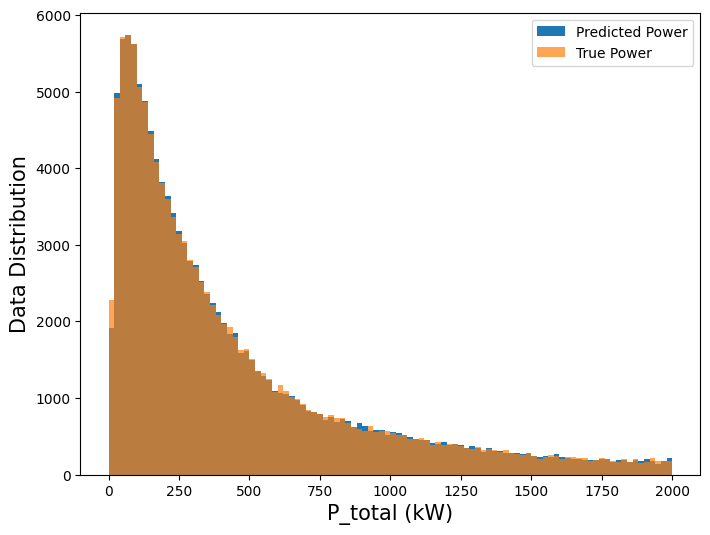

In [4]:
features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

# Plot distributions of P_res in kW
Ptotal_data = model_tf.predict(features_dataset)
plt.figure(figsize=(8,6))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='Predicted Power')
plt.xlabel('P_total (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
#plt.title('Predicted Power',fontsize=20)
#plt.show()

Ptotal_data = P_dataset
#plt.figure(figsize=(4,4))
plt.hist(Ptotal_data/1000, range=[0, 2000], bins=100,label='True Power',alpha=0.7)
#plt.xlabel('P_total (kW)',fontsize=15)
#plt.ylabel('Data Distribution',fontsize=15)
#plt.title('True Power',fontsize=20)
plt.legend()
plt.show()

# **Prepare data**

Load, preprocess and split dat into test and calibration sets

In [5]:
def standarize(X, X_mean, X_std):
    return (X - X_mean) / X_std
def standarize_inv(X, X_mean, X_std):
    return X * X_std + X_mean

In [7]:
features_dataset = pd.read_csv('./Dataset_test_features_UQ.csv')
P_dataset = pd.read_csv('./Dataset_test_P_UQ.csv')

# Remove the first column (unnamed) if it exists
features_dataset = features_dataset.drop(columns=['Unnamed: 0'], errors='ignore')
P_dataset = P_dataset.drop(columns=['Unnamed: 0'], errors='ignore')

# Standarize Y data. X data is already standarized
P_mean = 444860.879260
P_std = 446349.165241
#P_dataset = (P_dataset - P_mean) / P_std
P_dataset = standarize(P_dataset,P_mean,P_std)

sample_size = 10000

# Take a random sample
features_sample = features_dataset.sample(n=sample_size, random_state=42)
P_sample = P_dataset.loc[features_sample.index]  # Use the same indices for P_dataset

print(P_dataset.columns)
print(features_dataset.columns)
print(P_dataset.shape)
print(features_dataset.shape)

print(P_sample.shape)
print(features_sample.shape)

Index(['P'], dtype='object')
Index(['V', 'theta', 'W', 'theta.1', 'nacelle_temperature', 'V.1',
       'Vane_angle', 'Out_temperature', 'W.1', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
(120530, 1)
(120530, 11)
(10000, 1)
(10000, 11)


In [8]:
# Convert pd dataframe to numpy 
features_sample = features_sample.to_numpy()
P_sample = P_sample.to_numpy()

# Split data
X_cal, X_test, y_cal, y_test = train_test_split(features_sample, P_sample, test_size=0.5, random_state=42)
""" features_dataset = features_dataset.to_numpy()
P_dataset = P_dataset.to_numpy()
X_cal, X_test, y_cal, y_test = train_test_split(features_dataset, P_dataset, test_size=0.5, random_state=42) """
print(X_cal.shape)
print(y_cal.shape)
print(X_test.shape)
print(y_test.shape)

y_cal = y_cal.flatten()
y_test = y_test.flatten()

(5000, 11)
(5000, 1)
(5000, 11)
(5000, 1)


# **Train and save models**

Create, train and save Keras models:

* `model_up` with tau = (1-alpha)/2
* `model_low` with tau = alpha/2
* `model` with tau = 0.5

In [9]:
alpha = .1

def pinball_loss(y_true, y_pred, tau=0.5):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(tau * error, (tau - 1) * error))

def plot_loss(history):
    
    # Plot the loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [P_res]')
    plt.legend()
    plt.grid(True)

    val_loss_per_epoch = history.history['val_loss']
    train_loss_per_epoch = history.history['loss']
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))


Epoch 1/150
125/125 [==============================] - 1s 2ms/step - loss: 69986.1562 - val_loss: 8228.9404
Epoch 2/150
125/125 [==============================] - 0s 1ms/step - loss: 6059.5762 - val_loss: 3935.3464
Epoch 3/150
125/125 [==============================] - 0s 1ms/step - loss: 3553.7422 - val_loss: 2851.4727
Epoch 4/150
125/125 [==============================] - 0s 1ms/step - loss: 2548.5254 - val_loss: 2305.2385
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 1951.0062 - val_loss: 1864.3512
Epoch 6/150
125/125 [==============================] - 0s 1ms/step - loss: 1614.9031 - val_loss: 1572.6447
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 1344.1473 - val_loss: 1396.9132
Epoch 8/150
125/125 [==============================] - 0s 1ms/step - loss: 1140.2572 - val_loss: 1218.3435
Epoch 9/150
125/125 [==============================] - 0s 1ms/step - loss: 1000.6780 - val_loss: 1090.8962
Epoch 10/150
125/125 [==============

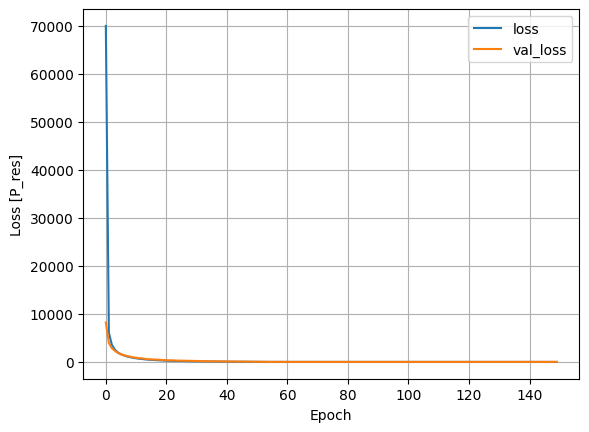

In [ ]:
""" # Train quantile estimator with same arquitecture than P model

model_up = load_model('modelP.keras')

loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=(1-alpha)/2)

model_up.compile(optimizer='adam', loss=loss_fn)

history_up = model_up.fit(X_cal, y_cal, epochs=150, batch_size=32, validation_split=.2)

model_up.save('modelP_up.keras')

plot_loss(history_up) """

Epoch 1/150
125/125 [==============================] - 1s 2ms/step - loss: 107134.9062 - val_loss: 6051.7510
Epoch 2/150
125/125 [==============================] - 0s 1ms/step - loss: 5124.0903 - val_loss: 3244.8918
Epoch 3/150
125/125 [==============================] - 0s 1ms/step - loss: 2739.2063 - val_loss: 1763.3406
Epoch 4/150
125/125 [==============================] - 0s 1ms/step - loss: 1708.0491 - val_loss: 1314.8524
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 1217.2681 - val_loss: 1177.2802
Epoch 6/150
125/125 [==============================] - 0s 1ms/step - loss: 977.7893 - val_loss: 884.2056
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 839.0789 - val_loss: 817.0183
Epoch 8/150
125/125 [==============================] - 0s 1ms/step - loss: 715.5603 - val_loss: 794.6010
Epoch 9/150
125/125 [==============================] - 0s 1ms/step - loss: 617.6865 - val_loss: 729.5705
Epoch 10/150
125/125 [=====================

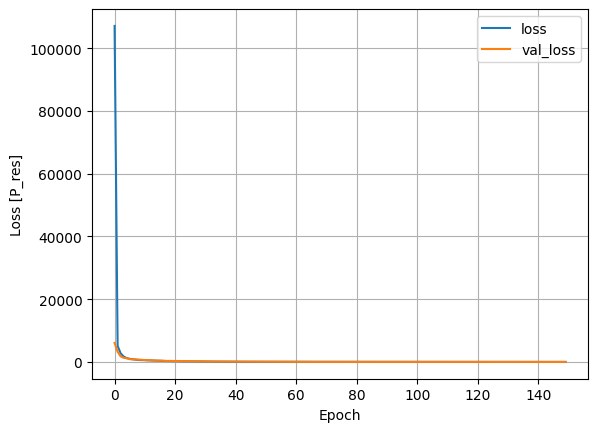

In [ ]:
""" # Train quantile estimator with same arquitecture than P model

model_low = load_model('modelP.keras')

loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=alpha/2)

model_low.compile(optimizer='adam', loss=loss_fn)

history_low = model_low.fit(X_cal, y_cal, epochs=150, batch_size=32, validation_split=.2)

model_up.save('modelP_low.keras')

plot_loss(history_low) """

In [44]:
# Define the model architecture
def create_model(input_shape, tau):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Single output for quantile regression
    ])
    loss_fn = lambda y_true, y_pred: pinball_loss(y_true, y_pred, tau=tau)
    model.compile(optimizer=Adam(), loss=loss_fn)
    return model

Epoch 1/150
125/125 [==============================] - 1s 2ms/step - loss: 0.0548 - val_loss: 0.0273
Epoch 2/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 3/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0259
Epoch 4/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0250 - val_loss: 0.0227
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 6/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0297
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0249 - val_loss: 0.0267
Epoch 8/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0219
Epoch 9/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0243 - val_loss: 0.0246
Epoch 10/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0225 - val_lo

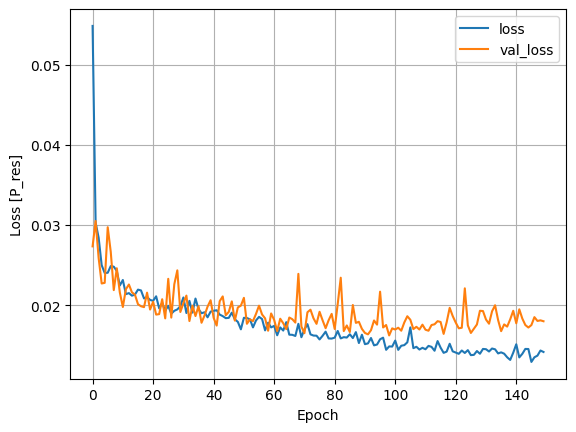

In [45]:
# Train quantile estimations with a neural network

# Parameters
input_shape = X_cal.shape[1]
tau = (1 - alpha) / 2

# Create the model
model_up = create_model(input_shape, tau)

# Train the model
history_up = model_up.fit(X_cal, y_cal, epochs=150, batch_size=32, validation_split=0.2)

# Save the model
model_up.save('modelP_up.keras')

plot_loss(history_up)

Epoch 1/150
125/125 [==============================] - 1s 2ms/step - loss: 0.0330 - val_loss: 0.0106
Epoch 2/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 3/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 4/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 5/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 6/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0084
Epoch 7/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 8/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 9/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 10/150
125/125 [==============================] - 0s 1ms/step - loss: 0.0066 - val_lo

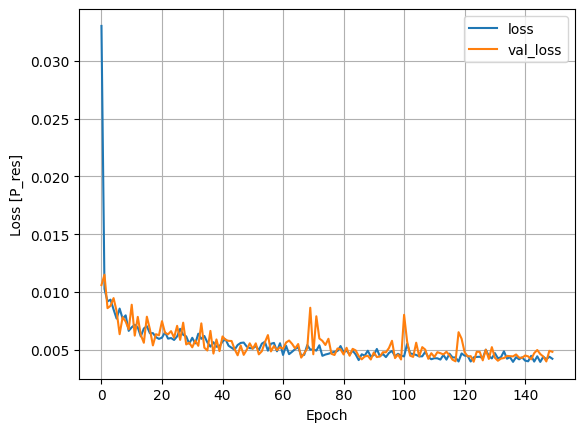

In [46]:
# Parameters
input_shape = X_cal.shape[1]
tau = alpha / 2

# Create the model
model_low = create_model(input_shape, tau)

# Train the model
history_low = model_low.fit(X_cal, y_cal, epochs=150, batch_size=32, validation_split=0.2)

# Save the model
model_low.save('modelP_low.keras')

plot_loss(history_low)

In [47]:
# Define the inverse scaling function
def create_scaled_output_model(P_model, P_std, P_mean):
    """
    Creates a new model that applies scaling to the output of a given pre-trained model.

    Args:
        P_model (tf.keras.Model): The pre-trained model.
        P_std (float): The scaling standard deviation.
        P_mean (float): The scaling mean.

    Returns:
        tf.keras.Model: A new model with scaled output.
    """
    inputs = P_model.input
    P = P_model.output

    # Apply the scaling transformation: P' = P * P_std + P_mean
    P_prime = P * P_std + P_mean

    # Create and return the new model
    scaled_model = tf.keras.Model(inputs=inputs, outputs=P_prime)
    return scaled_model

In [48]:
model_up_units = create_scaled_output_model(model_up,P_std,P_mean)
model_up_units.save('modelP_up_units.keras')
model_low_units = create_scaled_output_model(model_low,P_std,P_mean)
model_low_units.save('modelP_low_units.keras')


In [49]:
# Check quantile estimations

P_pred = model_tf.predict(X_test).flatten()
P_low = model_low_units.predict(X_test).flatten()
P_up = model_up_units.predict(X_test).flatten()
#P_low = standarize_inv(model_low.predict(X_test).flatten(),P_mean,P_std)
#P_up = standarize_inv(model_up.predict(X_test).flatten(),P_mean,P_std)

for i in range(10):
    print(P_pred[i],P_low[i],P_up[i])

157/157 [==============================] - 0s 533us/step
482274.4 451908.8 492576.7
1071359.9 970480.25 1049174.5
158646.81 162157.6 162693.31
163489.5 160685.19 164103.81
148274.11 142674.66 146068.47
1975141.4 1846604.0 2028688.2
62651.652 56331.5 65184.562
1517551.0 1396425.2 1548680.8
1252351.6 1116477.1 1261742.2
106556.89 95449.31 108298.16


# **MAPIE**

Load and wrap for `sklearn` compatibility (the wrapper assumes that the model is already trained):

In [51]:
class TrainedKerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def __sklearn_is_fitted__(self):
        return True

#model_files = ['modelP.keras', 'modelP.keras', 'modelP.keras']
#model_files = ['modelP_low.keras', 'modelP_up.keras', 'modelP.keras']
model_files = ['modelP_low_units.keras', 'modelP_up_units.keras', 'modelP.keras']
wrapped_models = []

for file in model_files:
    loaded_model = load_model(file, compile=False)
    wrapped_model = TrainedKerasRegressorWrapper(loaded_model)
    wrapped_models.append(wrapped_model)

MAPIE quantile regression.

The list of estimators consist of:

* [0]: Estimator with quantile value of alpha/2
* [1]: Estimator with quantile value of 1 - alpha/2
* [2]: Estimator with quantile value of 0.5
```

In [52]:
mapie_regressor = MapieQuantileRegressor(
    estimator=wrapped_models, cv='prefit')

mapie_regressor.fit(X_cal, standarize_inv(y_cal,P_mean,P_std))

predictions, intervals = mapie_regressor.predict(X_test)

lower_intervals = intervals[:, 0]
upper_intervals = intervals[:, 1]

results = pd.DataFrame({
    'Prediction': predictions.flatten(),
    'Lower Interval': lower_intervals.flatten(),
    'Upper Interval': upper_intervals.flatten(),
    'Amplitude': upper_intervals.flatten() - lower_intervals.flatten(),
    'Actual Value': standarize_inv(y_test,P_mean,P_std)
})

results.head()

157/157 [==============================] - 0s 446us/step


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(


157/157 [==============================] - 0s 584us/step


/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


,Prediction,Lower Interval,Upper Interval,Amplitude,Actual Value
0,4.822744e+05,440978.40625,5.035071e+05,62528.68750,464149.99
1,1.071360e+06,959549.84375,1.060105e+06,100555.06250,1071689.90
2,1.586468e+05,151227.18750,1.736237e+05,22396.53125,158800.00
3,1.634895e+05,149754.78125,1.750342e+05,25279.43750,163480.00
4,1.482741e+05,131744.25000,1.569989e+05,25254.62500,145710.01


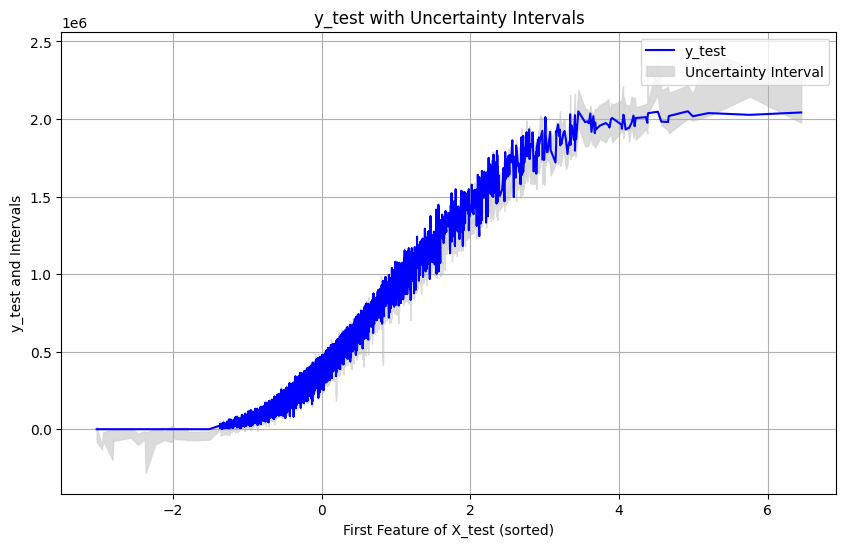

In [54]:

# Example data (use your actual X_test, y_test, and intervals)
# X_test: shape (5000, 11), y_test: shape (5000,), intervals: shape (5000, 2, 1)
first_feature = X_test[:, 0]  # Extract the first feature
y_test = np.array(y_test)    # Ensure y_test is a NumPy array
lower_limit = intervals[:, 0, 0]  # Extract lower limit from intervals
upper_limit = intervals[:, 1, 0]  # Extract upper limit from intervals

# Sort by the first feature
sorted_indices = np.argsort(first_feature)
first_feature_sorted = first_feature[sorted_indices]
y_test_sorted = y_test[sorted_indices]
lower_limit_sorted = lower_limit[sorted_indices]
upper_limit_sorted = upper_limit[sorted_indices]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(first_feature_sorted, standarize_inv(y_test_sorted,P_mean,P_std), label='y_test', color='blue', linewidth=1.5)
plt.fill_between(first_feature_sorted, lower_limit_sorted, upper_limit_sorted, color='lightgray', alpha=0.8, label='Uncertainty Interval')
plt.xlabel('First Feature of X_test (sorted)')
plt.ylabel('y_test and Intervals')
plt.title('y_test with Uncertainty Intervals')
plt.legend()
plt.grid(True)
plt.show()